# LEGO Bricks ML Vision - Training Pipeline Demonstration

This notebook provides a step-by-step demonstration of training the YOLO-based computer vision models for detecting LEGO bricks and studs. The training pipeline showcases how to:

1. Prepare and process LEGO brick/stud datasets
2. Configure and train YOLOv8 models 
3. Evaluate model performance
4. Export models for inference

## Project Overview

The LEGO Bricks ML Vision project uses two distinct computer vision models:
- **Brick Detection Model**: Identifies complete LEGO bricks in images
- **Stud Detection Model**: Identifies individual studs on LEGO bricks

Together, these models enable the full classification pipeline that can identify brick dimensions based on stud patterns.

![Training Pipeline Overview](../docs/assets/images/train_pipeline_diagram.png)

## 1. Setup and Environment Configuration

In [7]:
# Check for "LEGO_BRICKS_ML_VISION" folder in the cwd folder branch

import os
import sys
from pathlib import Path
import subprocess
import rich.logging as rlog
import logging

# Set up rich logger
logger = logging.getLogger("notebook_logger")
if not logger.handlers:
    handler = rlog.RichHandler(rich_tracebacks=True, markup=True)
    logger.setLevel(logging.INFO)
    logger.addHandler(handler)

def check_repo_clone():
    """
    Check if the cwd name matches the repo name.
    If not, check if the parent folder matches the repo name.
    If not, clone the repo.

    Returns the local repo root path and adds it to the sys.path
    """
    userGithub = "MiguelDiLalla"
    repoGithub = "LEGO_Bricks_ML_Vision"
    repo_url = f"https://github.com/{userGithub}/{repoGithub}.git"

    cwd = Path.cwd()
    cwd_name = cwd.name
    cwd_parent = cwd.parent

    if cwd_name != repoGithub and cwd_parent.name != repoGithub:
        logger.info(f"Cloning [bold blue]{repoGithub}[/bold blue] repository from GitHub...")
        try:
            subprocess.run(["git", "clone", repo_url], check=True, capture_output=True)
            logger.info(f"[bold green]Repository successfully cloned[/bold green]")
            # Add the repo to the sys.path
            sys.path.append(cwd / repoGithub)
            # Change the cwd to the repo root
            os.chdir(cwd / repoGithub)
            return cwd / repoGithub
        except subprocess.CalledProcessError as e:
            logger.error(f"[bold red]Failed to clone repository:[/bold red] {e}")
            logger.error(f"Error output: {e.stderr.decode('utf-8') if e.stderr else 'None'}")
            raise
    else:
        repo_path = cwd if cwd_name == repoGithub else cwd_parent
        logger.info(f"Repository [bold blue]{repoGithub}[/bold blue] already available at: [green]{repo_path}[/green]")
        # Add the repo to the sys.path
        sys.path.append(repo_path)
        # Change the cwd to the repo root (and log it)
        os.chdir(repo_path)
        logger.info(f"Changed the cwd to the repository root at: [green]{repo_path}[/green]")

        
        return repo_path

repo_clone_path = check_repo_clone()


[03/07/25 20:58:24] INFO     Repository LEGO_Bricks_ML_Vision already available at:                ]8;id=926810;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\3503301611.py\3503301611.py]8;;\:]8;id=679978;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\3503301611.py#49\49]8;;\
                             c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision                              

                    INFO     Changed the cwd to the repository root at:                            ]8;id=23261;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\3503301611.py\3503301611.py]8;;\:]8;id=724299;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\3503301611.py#54\54]8;;\
                             c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision                              

In [8]:
def get_requirements(repo_path):
    """Get requirements from requirements.txt file in the repository."""
    req_path = repo_path / "requirements.txt"
    if not req_path.exists():
        logger.warning(f"Requirements file not found at [yellow]{req_path}[/yellow]")
        return None
    
    with open(req_path, "r") as f:
        requirements = f.read().splitlines()
    
    # Filter out comments and empty lines
    requirements = [req for req in requirements if req and not req.startswith('#')]
    logger.info(f"Found [bold green]{len(requirements)}[/bold green] packages in requirements file")
    return requirements

def install_requirements(requirements):
    """Install required packages with logging."""
    if not requirements:
        logger.warning("No requirements to install")
        return False
    
    logger.info("Installing requirements...")
    try:
        # Use --quiet flag to reduce output verbosity
        subprocess.run(["pip", "install", "--quiet", "-r", "requirements.txt"], check=True)
        logger.info("[bold green]Requirements successfully installed[/bold green]")
        return True
    except subprocess.CalledProcessError as e:
        logger.error(f"Failed to install requirements: [bold red]{e}[/bold red]")
        return False

# Get and install requirements
requirements = get_requirements(repo_clone_path)

if requirements:
    logger.info(f"Found [bold]{len(requirements)}[/bold] requirements")
    success = install_requirements(requirements)
    if success:
        logger.info("[bold green]All dependencies ready for LEGO ML Vision project[/bold green]")
else:
    logger.warning("[yellow]No requirements installed. Some functionality may be limited.[/yellow]")

# Log all imports that will be used throughout the notebook
logger.info("Main packages that will be used in this notebook:")
main_packages = [
    "numpy", "torch", "torchvision", "cv2", "PIL", 
    "matplotlib", "ultralytics", "albumentations"
]
for pkg in main_packages:
    if pkg in " ".join(requirements):
        logger.info(f"✓ [green]{pkg}[/green] will be available")

[03/07/25 20:59:02] INFO     Found 16 packages in requirements file                                ]8;id=894327;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=844286;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#13\13]8;;\

                    INFO     Found 16 requirements                                                 ]8;id=523210;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=702311;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#36\36]8;;\

                    INFO     Installing requirements...                                            ]8;id=844347;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=970808;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#22\22]8;;\

[03/07/25 20:59:08] INFO     Requirements successfully installed                                   ]8;id=715418;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=93744;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#26\26]8;;\

                    INFO     All dependencies ready for LEGO ML Vision project                     ]8;id=778605;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=34888;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#39\39]8;;\

                    INFO     Main packages that will be used in this notebook:                     ]8;id=75457;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=714385;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#44\44]8;;\

                    INFO     ✓ numpy will be available                                             ]8;id=77763;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=274386;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#51\51]8;;\

                    INFO     ✓ torch will be available                                             ]8;id=739119;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=765920;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#51\51]8;;\

                    INFO     ✓ torchvision will be available                                       ]8;id=273890;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=285853;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#51\51]8;;\

                    INFO     ✓ matplotlib will be available                                        ]8;id=805418;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=115041;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#51\51]8;;\

                    INFO     ✓ ultralytics will be available                                       ]8;id=863743;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=881090;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#51\51]8;;\

                    INFO     ✓ albumentations will be available                                    ]8;id=588651;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py\2393111203.py]8;;\:]8;id=893625;file://C:\Users\User\AppData\Local\Temp\ipykernel_19804\2393111203.py#51\51]8;;\

In [ ]:
# Import required libraries
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from IPython.display import Image, display
from ultralytics import YOLO
from PIL import Image as PILImage

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import project modules
from train import get_repo_root, setup_logging, detect_hardware, load_config
from train import unzip_dataset, validate_dataset, create_dataset_structure, create_yolo_dataset_split, augment_data
from train import select_model, train_model as run_training_pipeline



In [ ]:
# Repository local root

clone_repo_path = get_repo_root()

# Setup logging and load configuration
setup_logging()
config = load_config()

# Detect optimal hardware
device = detect_hardware()
print(f"Training will use device: {device}")

2025-03-07 19:05:05,283 - INFO - Logging initialized for training pipeline ✅
2025-03-07 19:05:05,286 - WARNING - No GPU or MPS device detected. Falling back to CPU. ⚠️


Training will use device: cpu


## 2. Dataset Exploration

Let's examine our dataset before training. We have separate datasets for brick detection and stud detection.

In [ ]:
# Extract and prepare datasets
brick_dataset_path = unzip_dataset("bricks")
stud_dataset_path = unzip_dataset("studs")

# Display dataset information
def display_dataset_info(mode):
    images_path, labels_path = validate_dataset(mode)
    image_count = len(list(Path(images_path).glob("*.jpg")))
    label_count = len(list(Path(labels_path).glob("*.txt")))
    
    print(f"\n{mode.capitalize()} Dataset:")
    print(f"- Images path: {images_path}")
    print(f"- Labels path: {labels_path}")
    print(f"- Total images: {image_count}")
    print(f"- Total labels: {label_count}")
    
    
    return images_path, labels_path

bricks_images_path, bricks_labels_path = display_dataset_info("bricks")
studs_images_path, studs_labels_path = display_dataset_info("studs")


2025-03-07 19:05:05,335 - INFO - Extracting LegoBricks_Dataset.zip... ✅
2025-03-07 19:05:12,316 - INFO - Dataset extracted to: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks ✅
2025-03-07 19:05:12,324 - INFO - Extracting BrickStuds_Dataset.zip... ✅
2025-03-07 19:05:20,607 - INFO - Dataset extracted to: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\studs ✅
2025-03-07 19:05:20,631 - INFO - Renamed C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\YOLO_txt_brick_labels -> C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\labels ✅
2025-03-07 19:05:20,672 - INFO - ✅ Dataset validation completed for mode: bricks ✅
2025-03-07 19:05:20,740 - ERROR - Error during dataset validation: [WinError 5] Acceso denegado: 'C:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\cache/datasets\\studs\\YOLO_txt_studs_labels' -> 'C:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Visio


Bricks Dataset:
- Images path: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\images
- Labels path: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\labels
- Total images: 1803
- Total labels: 1803

Studs Dataset:
- Images path: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\studs\images
- Labels path: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\studs\labels
- Total images: 2176
- Total labels: 0


### Visualize Sample Images with Annotations


===== Brick Detection Dataset Samples =====


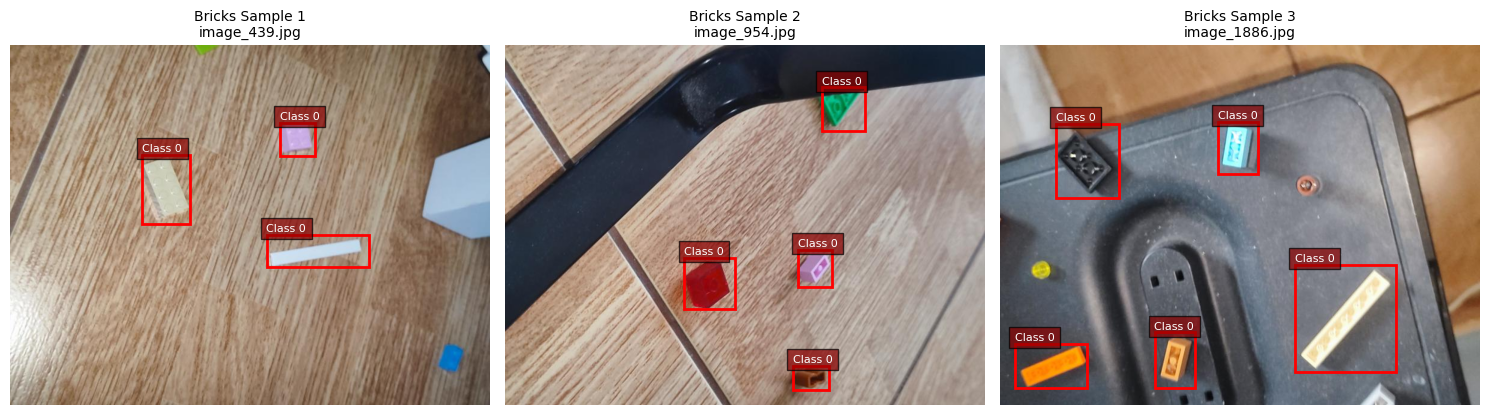


===== Stud Detection Dataset Samples =====


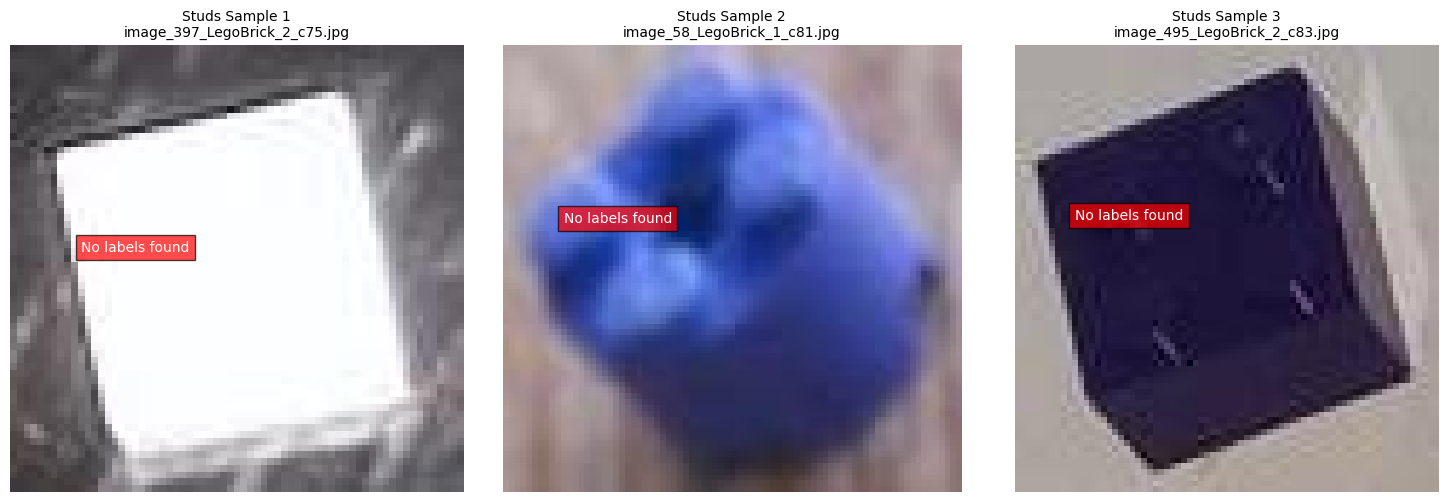

In [ ]:
import random

def visualize_sample_with_annotations(images_path, labels_path, mode, num_samples=3):
    """
    Visualize sample images with their YOLO format annotations.
    
    Args:
        images_path: Path to images directory
        labels_path: Path to labels directory 
        mode: Either "bricks" or "studs" to determine visualization style
        num_samples: Number of samples to visualize
    """
    # Get image files and ensure we don't exceed available samples
    image_files = list(Path(images_path).glob("*.jpg"))
    num_samples = min(num_samples, len(image_files))
    samples = random.sample(image_files, num_samples)
    
    # Create figure for horizontal layout
    fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 5))
    if num_samples == 1:
        axes = [axes]  # Make iterable for single sample case
        
    # Define colors based on mode
    colors = {
        "bricks": {"box": "red", "text_bg": "darkred"},
        "studs": {"box": "blue", "text_bg": "darkblue"}
    }
    color = colors.get(mode, {"box": "green", "text_bg": "darkgreen"})
    
    for i, (img_path, ax) in enumerate(zip(samples, axes)):
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]
        
        # Display image
        ax.imshow(img)
        ax.set_title(f"{mode.capitalize()} Sample {i+1}\n{img_path.name}", fontsize=10)
        ax.axis('off')  # Hide axis for cleaner visualization
        
        # Try to find the corresponding label file
        label_file = Path(labels_path) / f"{img_path.stem}.txt"
        
        # If not found directly, check subdirectories
        if not label_file.exists():
            parent_dir = Path(labels_path).parent
            for subdir in ['train', 'val', 'test']:
                alt_path = parent_dir / subdir / "labels" / f"{img_path.stem}.txt"
                if alt_path.exists():
                    label_file = alt_path
                    break
        
        # Load and draw annotations if label file exists
        if label_file.exists():
            with open(label_file, 'r') as f:
                annotations = f.readlines()
            
            # Process each annotation
            for ann in annotations:
                parts = ann.strip().split()
                if len(parts) >= 5:  # Ensure valid YOLO format
                    class_id = int(float(parts[0]))
                    x_center, y_center, w, h = map(float, parts[1:5])
                    
                    # Convert normalized YOLO coordinates to pixel values
                    x1 = int((x_center - w/2) * width)
                    y1 = int((y_center - h/2) * height)
                    x2 = int((x_center + w/2) * width)
                    y2 = int((y_center + h/2) * height)
                    
                    # Draw bounding box
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                        fill=False, edgecolor=color["box"], linewidth=2)
                    ax.add_patch(rect)
                    
                    # Add label text with background
                    ax.text(x1, y1-5, f"Class {class_id}", color='white', fontsize=8,
                           bbox=dict(facecolor=color["text_bg"], alpha=0.7))
        else:
            ax.text(10, 30, "No labels found", color='white', fontsize=10,
                   bbox=dict(facecolor='red', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Display dataset samples with annotations
print("\n===== Brick Detection Dataset Samples =====")
visualize_sample_with_annotations(bricks_images_path, bricks_labels_path, "bricks")

print("\n===== Stud Detection Dataset Samples =====")
visualize_sample_with_annotations(studs_images_path, studs_labels_path, "studs")

### Create YOLO training structure:

In [ ]:
# create_dataset_structure("bricks")

2025-03-07 19:05:22,806 - INFO - ✅ Dataset structure created at C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache\datasets\bricks_yolo ✅


WindowsPath('C:/Users/User/Projects_Unprotected/LEGO_Bricks_ML_Vision/cache/datasets/bricks_yolo')

### Split into train, validation, and test sets:

In [6]:
bricks_dataset_path = create_yolo_dataset_split("bricks")

2025-03-07 19:05:22,841 - INFO - Starting dataset split for bricks mode ✅
2025-03-07 19:05:22,846 - INFO - Source dataset: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks ✅
2025-03-07 19:05:22,848 - INFO - Output directory: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks_yolo ✅
2025-03-07 19:05:22,857 - INFO - Found 1803 images in dataset ✅
2025-03-07 19:05:22,862 - INFO - Files randomly shuffled for unbiased split ✅
2025-03-07 19:05:22,865 - INFO - Split sizes: 1262 train, 360 validation, 181 test ✅
2025-03-07 19:05:22,867 - INFO - Creating YOLO directory structure ✅
2025-03-07 19:05:22,875 - INFO - Copying files to train split... ✅
2025-03-07 19:05:45,579 - INFO - Copied 1262 image-label pairs to dataset/images/train ✅
2025-03-07 19:05:45,581 - INFO - Copying files to validation split... ✅
2025-03-07 19:05:51,449 - INFO - Copied 360 image-label pairs to dataset/images/val ✅
2025-03-07 19:05:51,450 - INFO - Copying files to

### Augment Training Data using Albumentations:

In [ ]:
augment_data(bricks_dataset_path)

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'bricks\\dataset/images/train'

## 3. Training the Brick Detection Model

Now let's train the YOLOv8 model for brick detection. We'll use the training pipeline from `train.py`.

In [ ]:
# Training configuration for the brick detection model
brick_training_params = {
    "dataset_path": brick_dataset_path,
    "model_path": select_model("bricks", use_pretrained=True),
    "device": device,
    "epochs": 50,
    "batch_size": 16,
    "repo_root": project_root
}

print("Starting Brick Detection Model Training...")
print(f"Parameters: {brick_training_params}")

# Run the training pipeline (set to shorter epochs for demo purposes)
try:
    brick_results_dir = run_training_pipeline(**brick_training_params)
    print(f"\nTraining completed. Results saved to: {brick_results_dir}")
except Exception as e:
    print(f"Training error: {e}")

2025-03-07 14:03:01,234 - INFO - ✅ Model selected: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation/Models_DEMO\Brick_Model_best20250123_192838t.pt ✅
2025-03-07 14:03:01,236 - INFO - 🚀 Starting training with model: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation/Models_DEMO\Brick_Model_best20250123_192838t.pt ✅
2025-03-07 14:03:01,410 - INFO - Project path: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\results ✅


Starting Brick Detection Model Training...
Parameters: {'dataset_path': 'C:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\cache/datasets\\bricks', 'model_path': 'C:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\presentation/Models_DEMO\\Brick_Model_best20250123_192838t.pt', 'device': 'cpu', 'epochs': 50, 'batch_size': 16}
Training error: Command '['yolo', 'train', 'model=C:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\presentation/Models_DEMO\\Brick_Model_best20250123_192838t.pt', 'data=C:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\cache/datasets\\bricks/dataset.yaml', 'epochs=50', 'batch=16', 'device=cpu', 'project=c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks\\results', 'name=training_20250307_140301', 'patience=3', 'single_cls=True', 'exist_ok=True']' returned non-zero exit status 1.


### Visualize Brick Detection Training Results

In [ ]:
# Display training metrics
try:
    # Display confusion matrix
    confusion_matrix_path = Path(brick_results_dir) / "confusion_matrix.png"
    if confusion_matrix_path.exists():
        display(Image(str(confusion_matrix_path)))
    
    # Display results plot
    results_plot_path = Path(brick_results_dir) / "results.png"
    if results_plot_path.exists():
        display(Image(str(results_plot_path)))
        
    # Display validation examples
    val_images = list(Path(brick_results_dir) / "val_batch0_pred.jpg")
    if val_images:
        display(Image(str(val_images[0])))
except Exception as e:
    print(f"Error displaying results: {e}")

Error displaying results: name 'brick_results_dir' is not defined


## 4. Training the Stud Detection Model

Now we'll train the YOLOv8 model for detecting studs on LEGO bricks.

In [ ]:
# Training configuration for the stud detection model
stud_training_params = {
    "mode": "studs",
    "epochs": 50,  # Reduced for demonstration purposes
    "batch_size": 16,
    "use_pretrained": True,
    "device": device
}

print("Starting Stud Detection Model Training...")
print(f"Parameters: {stud_training_params}")

# Run the training pipeline
try:
    stud_results_dir = run_training_pipeline(**stud_training_params)
    print(f"\nTraining completed. Results saved to: {stud_results_dir}")
except Exception as e:
    print(f"Training error: {e}")

Starting Stud Detection Model Training...
Parameters: {'mode': 'studs', 'epochs': 50, 'batch_size': 16, 'use_pretrained': True, 'device': 'cpu'}
Training error: train_model() got an unexpected keyword argument 'mode'


### Visualize Stud Detection Training Results

In [ ]:
# Display training metrics
try:
    # Display confusion matrix
    confusion_matrix_path = Path(stud_results_dir) / "confusion_matrix.png"
    if confusion_matrix_path.exists():
        display(Image(str(confusion_matrix_path)))
    
    # Display results plot
    results_plot_path = Path(stud_results_dir) / "results.png"
    if results_plot_path.exists():
        display(Image(str(results_plot_path)))
        
    # Display validation examples
    val_images = list(Path(stud_results_dir) / "val_batch0_pred.jpg")
    if val_images:
        display(Image(str(val_images[0])))
except Exception as e:
    print(f"Error displaying results: {e}")

Error displaying results: name 'stud_results_dir' is not defined


## 5. Model Evaluation on Test Images

Let's test our trained models on some unseen images to see how they perform.

In [ ]:
# Load the best trained models
try:
    brick_model_path = Path(brick_results_dir) / "weights" / "best.pt"
    stud_model_path = Path(stud_results_dir) / "weights" / "best.pt"
    
    brick_model = YOLO(str(brick_model_path))
    stud_model = YOLO(str(stud_model_path))
    
    print(f"Models loaded successfully")
except Exception as e:
    print(f"Error loading models: {e}")

Error loading models: name 'brick_results_dir' is not defined


In [ ]:
# Function to run inference on test images
def test_on_images(model, test_images_path, num_samples=3):
    test_images = list(Path(test_images_path).glob("*.jpg"))[:num_samples]
    
    plt.figure(figsize=(15, 5*num_samples))
    for i, img_path in enumerate(test_images):
        # Run prediction
        results = model(str(img_path))
        
        # Get result image
        result_img = results[0].plot()
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        
        # Plot image with predictions
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(result_img)
        plt.title(f"Test Image {i+1}: {img_path.name}")
        
    plt.tight_layout()
    plt.show()

# Create a function to load presentation images
def load_presentation_images():
    presentation_path = project_root / "presentation" / "images"
    
    if not presentation_path.exists():
        print(f"Presentation folder not found: {presentation_path}")
        print("Using test images instead.")
        return None
        
    image_files = list(presentation_path.glob("*.jpg"))
    if not image_files:
        print("No presentation images found. Using test images instead.")
        return None
        
    print(f"Found {len(image_files)} presentation images")
    return presentation_path, image_files

# Replace the test_on_images function call in the evaluation section with:
presentation_path, presentation_files = load_presentation_images()

if presentation_path:
    print("Using presentation images for model evaluation:")
    test_on_images(brick_model, presentation_path)
    test_on_images(stud_model, presentation_path)
else:
    print("Brick Detection Test Results:")
    test_img_path = Path(brick_dataset_path) / "test" / "images"
    test_on_images(brick_model, test_img_path)
    
    print("Stud Detection Test Results:")
    test_img_path = Path(stud_dataset_path) / "test" / "images"
    test_on_images(stud_model, test_img_path)

Presentation folder not found: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\images
Using test images instead.


TypeError: cannot unpack non-iterable NoneType object

## 6. Complete Inference Pipeline Example

Now let's demonstrate how both models work together in the complete inference pipeline:

In [ ]:
# Import the full inference pipeline
from utils.model_utils import detect_bricks, detect_studs_on_brick, classify_brick_by_studs

def run_complete_pipeline(image_path):
    # Load image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Step 1: Detect bricks
    brick_results = detect_bricks(image_path, model_path=brick_model_path)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    
    # Create a copy for visualization
    result_img = img_rgb.copy()
    height, width = result_img.shape[:2]
    
    # Process each detected brick
    for i, brick in enumerate(brick_results):
        # Extract brick coordinates
        x1, y1, x2, y2 = brick['bbox']
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Crop brick image
        brick_img = img_rgb[y1:y2, x1:x2]
        
        # Step 2: Detect studs on this brick
        studs = detect_studs_on_brick(brick_img, model_path=stud_model_path)
        
        # Step 3: Classify brick by stud pattern
        brick_type = classify_brick_by_studs(studs, brick_img.shape[:2])
        
        # Draw brick bounding box
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        # Draw studs and add text
        for stud in studs:
            sx1, sy1, sx2, sy2 = stud['bbox']
            sx1, sy1, sx2, sy2 = int(sx1), int(sy1), int(sx2), int(sy2)
            # Adjust coordinates to be relative to the original image
            sx1, sy1, sx2, sy2 = sx1 + x1, sy1 + y1, sx2 + x1, sy2 + y1
            cv2.rectangle(result_img, (sx1, sy1), (sx2, sy2), (0, 255, 0), 1)
        
        # Add brick type label
        cv2.putText(result_img, f"Brick: {brick_type}", (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.subplot(1, 2, 2)
    plt.imshow(result_img)
    plt.title("Complete Pipeline Results")
    plt.tight_layout()
    plt.show()

# Run the complete pipeline on a test image
if presentation_files:
    test_image = presentation_files[0]  # Use first presentation image
    print(f"Running complete pipeline on presentation image: {test_image.name}")
else:
    test_image = list(Path(brick_dataset_path) / "test" / "images")[0]
    print(f"Running complete pipeline on test image: {test_image.name}")
    
run_complete_pipeline(test_image)

## 7. Conclusion and Next Steps

In this notebook, we've demonstrated the complete training pipeline for LEGO Bricks ML Vision project:

1. We prepared and explored the datasets for both brick and stud detection
2. We trained YOLOv8 models for both tasks
3. We evaluated the models on test images
4. We demonstrated the complete inference pipeline

### Key Takeaways
- YOLOv8 provides excellent performance for this object detection task
- The two-stage detection approach (bricks → studs) works well for dimension classification
- Pre-trained models significantly improve training time and performance

### Potential Improvements
- **Data augmentation**: Add more augmentation techniques to improve robustness
- **Model optimization**: Experiment with different YOLOv8 model sizes
- **Transfer learning**: Fine-tune from models trained on similar objects
- **Hyperparameter tuning**: Optimize learning rates, batch sizes, etc.

### Next Steps
- Deploy models to the main application
- Consider dataset expansion through community contributions
- Test on more challenging real-world images

This training pipeline provides reproducible model training for the LEGO Bricks ML Vision project, ensuring consistent performance across different environments.